# Croissant 🥐 Online Health Report

## Example of [hf.co/datasets](https://huggingface.co/datasets)

This notebook is based on the output produced after crawling [huggingface.co/datasets](https://huggingface.co/datasets). See the README for more details.

At the moment, we only crawl Hugging Face which is why the report is custom for Hugging Face. We will enrich other repositories in the future (Kaggle, OpenML). The goal here is to make the Croissant ecosystem better by analyzing issues.

In [1]:
import sys

from etils import epath
from IPython.display import Markdown
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns

sns.set()

source = "huggingface"  # Name of the scrapy spider

folder = epath.Path(sys.path[0]) / "../data"
files = folder.glob("*/*.parquet")
df = pl.scan_parquet(files).filter(pl.col("source") == source)

print(f"Report for {source}")

Report for huggingface


## 1. Responses overview

Scrapped 108049 datasets for huggingface

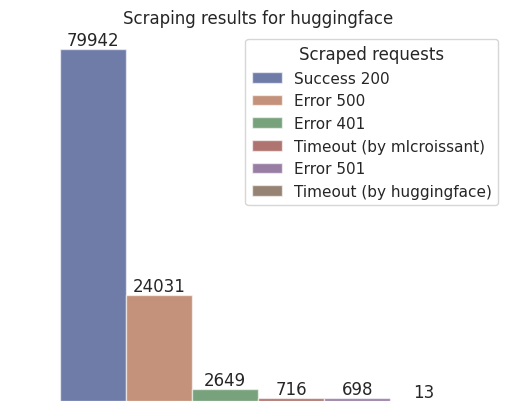

In [2]:
sns.set_style("white")

num_rows = df.select(pl.len()).collect().item()
display(Markdown(f"Scrapped {num_rows} datasets for {source}"))

has_timeout = pl.col("timeout_seconds").is_not_null()
has_croissant_timeout = pl.col("croissant_timeout_seconds").is_not_null()
data = df.filter(~has_timeout & ~has_croissant_timeout).group_by(pl.col("response_status")).len().sort(by="len", descending=True).collect()
num_timeouts = df.filter(has_timeout & ~has_croissant_timeout).select(pl.len()).collect().item()
num_croissant_timeouts = df.filter(~has_timeout & has_croissant_timeout).select(pl.len()).collect().item()
labels = [f"Success {code}" if code == 200 else f"Error {code}" for code in data["response_status"]] + [f"Timeout (by {source})"] + ["Timeout (by mlcroissant)"]
data = list(data["len"]) + [num_timeouts] + [num_croissant_timeouts]
data = {'Scraped requests': labels, 'Number': data}
hue_order = [element[1] for element in sorted(zip(data["Number"], data["Scraped requests"]), reverse=True)]
ax = sns.barplot(y='Number', hue='Scraped requests', data=data, palette="dark", alpha=.6, hue_order=hue_order)
ax.set(yticklabels=[])
ax.set(ylabel=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.title(f"Scraping results for {source}")
sns.despine(left=True, bottom=True)
plt.show()

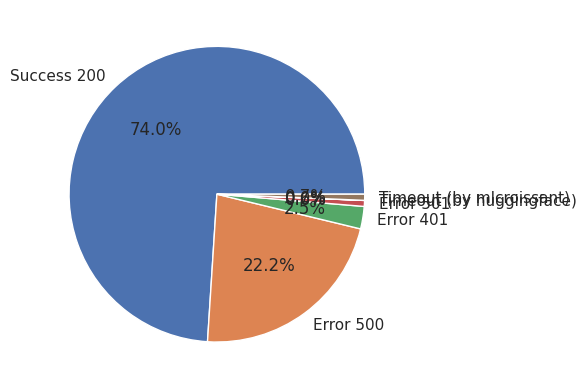

In [3]:
plt.pie(data["Number"], labels=data["Scraped requests"], autopct='%1.1f%%')
plt.show()

## 2. Croissant statistics

For the moment, we only count the number of `cr:Field`, `cr:RecordSet`, etc. We will enrich with more signals in the future.

In [4]:
columns = [
    "croissant_num_fields",
    "croissant_num_file_objects",
    "croissant_num_file_sets",
    "croissant_num_record_sets",
]
for column in columns:
    display(df.select(pl.col(column)).collect().describe(percentiles=[]))

statistic,croissant_num_fields
str,f64
"""count""",79800.0
"""null_count""",28249.0
"""mean""",3.436917
"""std""",7.870688
"""min""",0.0
"""max""",234.0


statistic,croissant_num_file_objects
str,f64
"""count""",79800.0
"""null_count""",28249.0
"""mean""",1.0
"""std""",0.0
"""min""",1.0
"""max""",1.0


statistic,croissant_num_file_sets
str,f64
"""count""",79800.0
"""null_count""",28249.0
"""mean""",1.044148
"""std""",1.797683
"""min""",0.0
"""max""",100.0


statistic,croissant_num_record_sets
str,f64
"""count""",79800.0
"""null_count""",28249.0
"""mean""",1.044148
"""std""",1.797683
"""min""",0.0
"""max""",100.0


## 3. In-depth errors

We now try to deep dive into the errors to understand why it fails.

In [5]:
# Report by type of errors

# List of errors that we currently know
CURRENTLY_KNOWN_ERRORS = [
    "<twisted.python.failure.Failure twisted.internet.error.TimeoutError",
    '{"error":"The dataset viewer doesn\'t support this dataset because it runs arbitrary python code.',
    '{"error":"The dataset does not exist, or is not accessible without authentication (private or gated).',
    '{"error":"The dataset is empty."',
]

rows_with_errors = ~has_timeout & ~has_croissant_timeout & pl.col("response_status") != 200
data = df.filter(rows_with_errors).group_by(pl.col("response_status")).agg(pl.col("body")).collect()
for row in data.rows(named=True):
    if row["response_status"] != 200:
        display(Markdown(f"### Status {row['response_status']}"))
        known_errors, unknown_errors = [], []
        for error in row["body"]:
            error = error.decode()
            if any(error.startswith(known_error) for known_error in CURRENTLY_KNOWN_ERRORS):
                known_errors.append(error)
            else:
                unknown_errors.append(error)
        if known_errors:
            display(Markdown(f"#### Known errors"))
            for error in known_errors[:10]:
                display(Markdown(f"- {error}"))
        if unknown_errors:
            display(Markdown(f"#### Unknown errors"))
            for error in unknown_errors[:10]:
                display(Markdown(f"- {error}"))

### Status 408

#### Known errors

- <twisted.python.failure.Failure twisted.internet.error.TimeoutError: User timeout caused connection failure: Getting https://datasets-server.huggingface.co/croissant?dataset=hearmeneigh/e621-rising-v2-curated took longer than 10 seconds..>

- <twisted.python.failure.Failure twisted.internet.error.TimeoutError: User timeout caused connection failure: Getting https://datasets-server.huggingface.co/croissant?dataset=Talik6876/Talik6876 took longer than 10 seconds..>

- <twisted.python.failure.Failure twisted.internet.error.TimeoutError: User timeout caused connection failure: Getting https://datasets-server.huggingface.co/croissant?dataset=common_voice took longer than 10 seconds..>

- <twisted.python.failure.Failure twisted.internet.error.TimeoutError: User timeout caused connection failure: Getting https://datasets-server.huggingface.co/croissant?dataset=slumericanBx/x took longer than 10 seconds..>

- <twisted.python.failure.Failure twisted.internet.error.TimeoutError: User timeout caused connection failure: Getting https://datasets-server.huggingface.co/croissant?dataset=aharley/rvl_cdip took longer than 10 seconds..>

- <twisted.python.failure.Failure twisted.internet.error.TimeoutError: User timeout caused connection failure: Getting https://datasets-server.huggingface.co/croissant?dataset=Tangliwen/Indian_Pines took longer than 10 seconds..>

- <twisted.python.failure.Failure twisted.internet.error.TimeoutError: User timeout caused connection failure: Getting https://datasets-server.huggingface.co/croissant?dataset=jeremygf/domains-causal took longer than 10 seconds..>

- <twisted.python.failure.Failure twisted.internet.error.TimeoutError: User timeout caused connection failure: Getting https://datasets-server.huggingface.co/croissant?dataset=open-llm-leaderboard/details_LeoLM__leo-hessianai-7b-chat-bilingual took longer than 10 seconds..>

- <twisted.python.failure.Failure twisted.internet.error.TimeoutError: User timeout caused connection failure: Getting https://datasets-server.huggingface.co/croissant?dataset=openclimatefix/goes-mrms took longer than 10 seconds..>

- <twisted.python.failure.Failure twisted.internet.error.TimeoutError: User timeout caused connection failure: Getting https://datasets-server.huggingface.co/croissant?dataset=dataDRVN/dog-wesley took longer than 10 seconds..>

### Status 501

#### Known errors

- {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

- {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

- {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

- {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

- {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

- {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

- {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

- {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

- {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

- {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

#### Unknown errors

- {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

- {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

- {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

- {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

- {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

- {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

- {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

- {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

- {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

- {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

### Status 401

#### Known errors

- {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

- {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

- {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

- {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

- {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

- {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

- {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

- {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

- {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

- {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

### Status 500

#### Known errors

- {"error":"The dataset is empty.","cause_exception":"EmptyDatasetError","cause_message":"The directory at hf://datasets/sicknd444/LainIwakuraV1@2af0e6bce0f7e231de8be925981684696f411db3 doesn't contain any data files","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1506, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, in get_module\n    patterns = get_data_patterns(base_path, download_config=self.download_config)\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/data_files.py\", line 460, in get_data_patterns\n    raise EmptyDatasetError(f\"The directory at {base_path} doesn't contain any data files\") from None\n","datasets.data_files.EmptyDatasetError: The directory at hf://datasets/sicknd444/LainIwakuraV1@2af0e6bce0f7e231de8be925981684696f411db3 doesn't contain any data files\n"]}

- {"error":"The dataset is empty.","cause_exception":"EmptyDatasetError","cause_message":"The directory at hf://datasets/Luan1/transcript@11ac2fdce5261338e08c4463f15c7649fe2b35e4 doesn't contain any data files","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1506, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, in get_module\n    patterns = get_data_patterns(base_path, download_config=self.download_config)\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/data_files.py\", line 460, in get_data_patterns\n    raise EmptyDatasetError(f\"The directory at {base_path} doesn't contain any data files\") from None\n","datasets.data_files.EmptyDatasetError: The directory at hf://datasets/Luan1/transcript@11ac2fdce5261338e08c4463f15c7649fe2b35e4 doesn't contain any data files\n"]}

- {"error":"The dataset is empty.","cause_exception":"EmptyDatasetError","cause_message":"The directory at hf://datasets/janPiljan/Wiki-Vital@690931515362fe9789fd5f09818b1232d195f1e3 doesn't contain any data files","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1506, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, in get_module\n    patterns = get_data_patterns(base_path, download_config=self.download_config)\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/data_files.py\", line 460, in get_data_patterns\n    raise EmptyDatasetError(f\"The directory at {base_path} doesn't contain any data files\") from None\n","datasets.data_files.EmptyDatasetError: The directory at hf://datasets/janPiljan/Wiki-Vital@690931515362fe9789fd5f09818b1232d195f1e3 doesn't contain any data files\n"]}

- {"error":"The dataset is empty.","cause_exception":"EmptyDatasetError","cause_message":"The directory at hf://datasets/JayWay/A1111SD_JupyterKag_custom-files@04e95312b1d10f7764b2f5d5cdb0d8163ff90767 doesn't contain any data files","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1506, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, in get_module\n    patterns = get_data_patterns(base_path, download_config=self.download_config)\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/data_files.py\", line 460, in get_data_patterns\n    raise EmptyDatasetError(f\"The directory at {base_path} doesn't contain any data files\") from None\n","datasets.data_files.EmptyDatasetError: The directory at hf://datasets/JayWay/A1111SD_JupyterKag_custom-files@04e95312b1d10f7764b2f5d5cdb0d8163ff90767 doesn't contain any data files\n"]}

- {"error":"The dataset is empty.","cause_exception":"EmptyDatasetError","cause_message":"The directory at hf://datasets/Darkme/SakamataChloe@d8fce702674f6b54a317777eb536e89a4e1f1d19 doesn't contain any data files","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1506, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, in get_module\n    patterns = get_data_patterns(base_path, download_config=self.download_config)\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/data_files.py\", line 460, in get_data_patterns\n    raise EmptyDatasetError(f\"The directory at {base_path} doesn't contain any data files\") from None\n","datasets.data_files.EmptyDatasetError: The directory at hf://datasets/Darkme/SakamataChloe@d8fce702674f6b54a317777eb536e89a4e1f1d19 doesn't contain any data files\n"]}

- {"error":"The dataset is empty.","cause_exception":"EmptyDatasetError","cause_message":"The directory at hf://datasets/nickthelegend/sadcolab@b70daa58126c4653a8be0a919354eea67571db96 doesn't contain any data files","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1506, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, in get_module\n    patterns = get_data_patterns(base_path, download_config=self.download_config)\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/data_files.py\", line 460, in get_data_patterns\n    raise EmptyDatasetError(f\"The directory at {base_path} doesn't contain any data files\") from None\n","datasets.data_files.EmptyDatasetError: The directory at hf://datasets/nickthelegend/sadcolab@b70daa58126c4653a8be0a919354eea67571db96 doesn't contain any data files\n"]}

- {"error":"The dataset is empty.","cause_exception":"EmptyDatasetError","cause_message":"The directory at hf://datasets/zhangshuai507653/testdataset@93efd427badcea632c6c6329ca9524ed20695419 doesn't contain any data files","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1506, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, in get_module\n    patterns = get_data_patterns(base_path, download_config=self.download_config)\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/data_files.py\", line 460, in get_data_patterns\n    raise EmptyDatasetError(f\"The directory at {base_path} doesn't contain any data files\") from None\n","datasets.data_files.EmptyDatasetError: The directory at hf://datasets/zhangshuai507653/testdataset@93efd427badcea632c6c6329ca9524ed20695419 doesn't contain any data files\n"]}

- {"error":"The dataset is empty.","cause_exception":"EmptyDatasetError","cause_message":"The directory at hf://datasets/vanziegler/dpr@9d89fc729093c5f6e39c857209f6a9dbc9af98b9 doesn't contain any data files","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1506, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, in get_module\n    patterns = get_data_patterns(base_path, download_config=self.download_config)\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/data_files.py\", line 460, in get_data_patterns\n    raise EmptyDatasetError(f\"The directory at {base_path} doesn't contain any data files\") from None\n","datasets.data_files.EmptyDatasetError: The directory at hf://datasets/vanziegler/dpr@9d89fc729093c5f6e39c857209f6a9dbc9af98b9 doesn't contain any data files\n"]}

- {"error":"The dataset is empty.","cause_exception":"EmptyDatasetError","cause_message":"The directory at hf://datasets/lilouuch/whisper_predictions_mgb3@5b5fda6dcabf3e3b609a87a28f4f1da5912a9af8 doesn't contain any data files","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1506, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, in get_module\n    patterns = get_data_patterns(base_path, download_config=self.download_config)\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/data_files.py\", line 460, in get_data_patterns\n    raise EmptyDatasetError(f\"The directory at {base_path} doesn't contain any data files\") from None\n","datasets.data_files.EmptyDatasetError: The directory at hf://datasets/lilouuch/whisper_predictions_mgb3@5b5fda6dcabf3e3b609a87a28f4f1da5912a9af8 doesn't contain any data files\n"]}

- {"error":"The dataset is empty.","cause_exception":"EmptyDatasetError","cause_message":"The directory at hf://datasets/lilouuch/whisper_predictions@b5710a4d419ed1c95fb0e65b5e9a1690775f19c8 doesn't contain any data files","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1506, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, in get_module\n    patterns = get_data_patterns(base_path, download_config=self.download_config)\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/data_files.py\", line 460, in get_data_patterns\n    raise EmptyDatasetError(f\"The directory at {base_path} doesn't contain any data files\") from None\n","datasets.data_files.EmptyDatasetError: The directory at hf://datasets/lilouuch/whisper_predictions@b5710a4d419ed1c95fb0e65b5e9a1690775f19c8 doesn't contain any data files\n"]}

#### Unknown errors

- {"error":"Cannot get the config names for the dataset.","cause_exception":"FileNotFoundError","cause_message":"Couldn't find a dataset script at /src/services/worker/ACCA225/starryfrp/starryfrp.py or any data file in the same directory. Couldn't find 'ACCA225/starryfrp' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in ACCA225/starryfrp. ","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1508, in dataset_module_factory\n    raise FileNotFoundError(\n","FileNotFoundError: Couldn't find a dataset script at /src/services/worker/ACCA225/starryfrp/starryfrp.py or any data file in the same directory. Couldn't find 'ACCA225/starryfrp' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in ACCA225/starryfrp. \n"]}

- {"error":"Cannot get the config names for the dataset.","cause_exception":"FileNotFoundError","cause_message":"Couldn't find a dataset script at /src/services/worker/safgasgfsa/Hitler-Voice/Hitler-Voice.py or any data file in the same directory. Couldn't find 'safgasgfsa/Hitler-Voice' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in safgasgfsa/Hitler-Voice. ","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1508, in dataset_module_factory\n    raise FileNotFoundError(\n","FileNotFoundError: Couldn't find a dataset script at /src/services/worker/safgasgfsa/Hitler-Voice/Hitler-Voice.py or any data file in the same directory. Couldn't find 'safgasgfsa/Hitler-Voice' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in safgasgfsa/Hitler-Voice. \n"]}

- {"error":"Cannot get the config names for the dataset.","cause_exception":"FileNotFoundError","cause_message":"Couldn't find a dataset script at /src/services/worker/plusbey/rellaria/rellaria.py or any data file in the same directory. Couldn't find 'plusbey/rellaria' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in plusbey/rellaria. ","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1508, in dataset_module_factory\n    raise FileNotFoundError(\n","FileNotFoundError: Couldn't find a dataset script at /src/services/worker/plusbey/rellaria/rellaria.py or any data file in the same directory. Couldn't find 'plusbey/rellaria' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in plusbey/rellaria. \n"]}

- {"error":"Cannot get the config names for the dataset.","cause_exception":"FileNotFoundError","cause_message":"Couldn't find a dataset script at /src/services/worker/xieyizheng/cv2/cv2.py or any data file in the same directory. Couldn't find 'xieyizheng/cv2' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in xieyizheng/cv2. ","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1508, in dataset_module_factory\n    raise FileNotFoundError(\n","FileNotFoundError: Couldn't find a dataset script at /src/services/worker/xieyizheng/cv2/cv2.py or any data file in the same directory. Couldn't find 'xieyizheng/cv2' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in xieyizheng/cv2. \n"]}

- {"error":"Cannot get the config names for the dataset.","cause_exception":"FileNotFoundError","cause_message":"Couldn't find a dataset script at /src/services/worker/LongshenOu/lyric-trans-en2zh-data/lyric-trans-en2zh-data.py or any data file in the same directory. Couldn't find 'LongshenOu/lyric-trans-en2zh-data' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in LongshenOu/lyric-trans-en2zh-data. ","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1508, in dataset_module_factory\n    raise FileNotFoundError(\n","FileNotFoundError: Couldn't find a dataset script at /src/services/worker/LongshenOu/lyric-trans-en2zh-data/lyric-trans-en2zh-data.py or any data file in the same directory. Couldn't find 'LongshenOu/lyric-trans-en2zh-data' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in LongshenOu/lyric-trans-en2zh-data. \n"]}

- {"error":"Cannot get the config names for the dataset.","cause_exception":"FileNotFoundError","cause_message":"Couldn't find a dataset script at /src/services/worker/navagg/PyVHR/PyVHR.py or any data file in the same directory. Couldn't find 'navagg/PyVHR' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in navagg/PyVHR. ","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1508, in dataset_module_factory\n    raise FileNotFoundError(\n","FileNotFoundError: Couldn't find a dataset script at /src/services/worker/navagg/PyVHR/PyVHR.py or any data file in the same directory. Couldn't find 'navagg/PyVHR' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in navagg/PyVHR. \n"]}

- {"error":"Cannot get the config names for the dataset.","cause_exception":"FileNotFoundError","cause_message":"Couldn't find a dataset script at /src/services/worker/shinnosuke7788/rvcbyshinno/rvcbyshinno.py or any data file in the same directory. Couldn't find 'shinnosuke7788/rvcbyshinno' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in shinnosuke7788/rvcbyshinno. ","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1508, in dataset_module_factory\n    raise FileNotFoundError(\n","FileNotFoundError: Couldn't find a dataset script at /src/services/worker/shinnosuke7788/rvcbyshinno/rvcbyshinno.py or any data file in the same directory. Couldn't find 'shinnosuke7788/rvcbyshinno' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in shinnosuke7788/rvcbyshinno. \n"]}

- {"error":"Cannot get the config names for the dataset.","cause_exception":"FileNotFoundError","cause_message":"Couldn't find a dataset script at /src/services/worker/dangvinh77/data_ticket/data_ticket.py or any data file in the same directory. Couldn't find 'dangvinh77/data_ticket' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in dangvinh77/data_ticket. ","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1508, in dataset_module_factory\n    raise FileNotFoundError(\n","FileNotFoundError: Couldn't find a dataset script at /src/services/worker/dangvinh77/data_ticket/data_ticket.py or any data file in the same directory. Couldn't find 'dangvinh77/data_ticket' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in dangvinh77/data_ticket. \n"]}

- {"error":"Cannot get the config names for the dataset.","cause_exception":"FileNotFoundError","cause_message":"Couldn't find a dataset script at /src/services/worker/tinago/gosiedan/gosiedan.py or any data file in the same directory. Couldn't find 'tinago/gosiedan' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in tinago/gosiedan. ","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1508, in dataset_module_factory\n    raise FileNotFoundError(\n","FileNotFoundError: Couldn't find a dataset script at /src/services/worker/tinago/gosiedan/gosiedan.py or any data file in the same directory. Couldn't find 'tinago/gosiedan' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in tinago/gosiedan. \n"]}

- {"error":"Cannot get the config names for the dataset.","cause_exception":"FileNotFoundError","cause_message":"Couldn't find a dataset script at /src/services/worker/zhangshuai507653/111/111.py or any data file in the same directory. Couldn't find 'zhangshuai507653/111' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in zhangshuai507653/111. ","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1508, in dataset_module_factory\n    raise FileNotFoundError(\n","FileNotFoundError: Couldn't find a dataset script at /src/services/worker/zhangshuai507653/111/111.py or any data file in the same directory. Couldn't find 'zhangshuai507653/111' on the Hugging Face Hub either: FileNotFoundError: No (supported) data files or dataset script found in zhangshuai507653/111. \n"]}

In [6]:
# Report by occurrence

rows_with_errors = ~has_timeout & ~has_croissant_timeout & pl.col("response_status") != 200
data = df.filter(rows_with_errors).group_by([pl.col("response_status"), pl.col("body")]).len().sort(by="len", descending=True).collect()

errors = data.filter(pl.col("response_status") != 200)
for error in errors.rows(named=True):
    if error["len"] > 5:
        display(Markdown(f"- **[{error['len']} similar errors]** [code {error['response_status']}]: {error['body'].decode()[:1000]}"))

- **[5081 similar errors]** [code 500]: {"error":"Unexpected error."}

- **[2649 similar errors]** [code 401]: {"error":"The dataset does not exist, or is not accessible without authentication (private or gated). Please check the spelling of the dataset name or retry with authentication."}

- **[650 similar errors]** [code 501]: {"error":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo."}

- **[337 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"DatasetWithScriptNotSupportedError","cause_message":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo.","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 65, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1512, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", li

- **[284 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"DatasetWithScriptNotSupportedError","cause_message":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo.","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 65, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1511, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", li

- **[74 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"DatasetWithScriptNotSupportedError","cause_message":"The dataset viewer doesn't support this dataset because it runs arbitrary python code. Please open a discussion in the discussion tab if you think this is an error and tag @lhoestq and @severo.","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 64, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1511, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", li

- **[39 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"ValueError","cause_message":"Seek before start of file","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1512, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1054, in get_m

- **[34 similar errors]** [code 501]: {"error":"Job manager was killed while running this job (job exceeded maximum duration)."}

- **[17 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"ValueError","cause_message":"Couldn't infer the same data file format for all splits. Got {NamedSplit('train'): ('json', {}), NamedSplit('validation'): ('json', {}), NamedSplit('test'): ('csv', {})}","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1512, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return H

- **[16 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"AttributeError","cause_message":"'NoneType' object has no attribute 'builder_configs'","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 361, in get_dataset_config_names\n    return list(builder_cls.builder_configs.keys()) or [dataset_module.builder_kwargs.get(\"config_name\", \"default\")]\n","AttributeError: 'NoneType' object has no attribute 'builder_configs'\n"]}

- **[15 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"BrokenPipeError","cause_message":"[Errno 32] Broken pipe","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1512, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1031, in get

- **[13 similar errors]** [code 501]: {"error":"Job manager crashed while running this job (missing heartbeats)."}

- **[12 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"BrokenPipeError","cause_message":"[Errno 32] Broken pipe","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1512, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1031, in get

- **[11 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"ValueError","cause_message":"Invalid IPv6 URL","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1495, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1472, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1042, in get_module\n  

- **[10 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"BadZipFile","cause_message":"File is not a zip file","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1512, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1054, in get_modu

- **[10 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"RuntimeError","cause_message":"generator raised StopIteration","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1512, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1047, i

- **[9 similar errors]** [code 500]: {"error":"Authentication check on the Hugging Face Hub failed or timed out. Please try again later, it's a temporary internal issue."}

- **[6 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"BadZipFile","cause_message":"File is not a zip file","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 65, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1511, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1488, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScript(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1053, in get_modu

- **[6 similar errors]** [code 500]: {"error":"Cannot get the config names for the dataset.","cause_exception":"ValueError","cause_message":"Couldn't infer the same data file format for all splits. Got {NamedSplit('train'): (None, {}), NamedSplit('test'): ('imagefolder', {})}","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/src/worker/job_runners/dataset/config_names.py\", line 55, in compute_config_names_response\n    for config in sorted(get_dataset_config_names(path=dataset, token=hf_token))\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/inspect.py\", line 351, in get_dataset_config_names\n    dataset_module = dataset_module_factory(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1512, in dataset_module_factory\n    raise e1 from None\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/datasets/load.py\", line 1489, in dataset_module_factory\n    return HubDatasetModuleFactoryWithoutScrip